In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from pprint import pprint
from sklearn.datasets import load_iris

In [2]:
df = pd.read_csv('iris.csv')
df.drop('Id', axis = 1, inplace = True)
df = df.rename(columns = {'species':'label'})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Split data into Train and Test dataset

In [3]:
def train_test_split(df,test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))
    
    indices = random.sample(df.index.tolist(),test_size)

    test_df = df.loc[indices]
    train_df = df.drop(indices)
    
    return train_df,test_df

In [4]:
random.seed(0)
train_df , test_df = train_test_split(df,0.1)

### Check Purity

In [5]:
def check_purity(data):
    
    # check for unique class label
    labels = data[:,-1]
    unique_label_column = np.unique(labels)
    if len(unique_label_column) == 1:
        return True
    else:
        return False

### Create Leaf

In [6]:
def create_leaf(data, ml_task):
    #Gives target labels as it is the last column in data
    labels = data[:,-1]
    #regression
    if ml_task == 'regression':
        leaf = np.mean(labels)
    #classification
    else:
        #returns the class which is unique
        classes,count_classes = np.unique(labels, return_counts=True)
        index = count_classes.argmax()
        leaf = classes[index]

    return leaf

### Potential Splits

In [7]:
def get_potential_splits(data):
    _,n_columns = data.shape
    potential_splits = {}
    #For every column, we have check for potential splits
    for column_index in range(n_columns-1):
        values = data[:,column_index]
        unique_values = np.unique(values)
        
        type_feature = FEATURE_TYPE[column_index]
        #For continuous features, potential splits will be middle value of 2 unique data points
        if type_feature == 'continuous': 
            potential_splits[column_index] = []
            for index in range(1,len(unique_values)):
                current_value = unique_values[index]
                prev_value = unique_values[index-1]
                potential_split = (current_value + prev_value)/2

                potential_splits[column_index].append(potential_split)
        #For discrete features, potential splits will be unique data points
        elif len(unique_values)>1:
            potential_splits[column_index] = unique_values

    return potential_splits

### Determinr Type of Fetaure

In [8]:
def detemine_type_of_feature(df):
    
    #determine whether the type of feature is categorical or continuous
    feature_type = []
    unique_value_threshold = 15
    for column in df.columns:
        if column != "label":
            unique_values = df[column].unique()        
            example_value = unique_values[0]
            #Checking if the value is string or has occured limited times
            if (isinstance(example_value, str)) or (len(unique_values) <= unique_value_threshold):
                feature_type.append('categorical')
            else:
                feature_type.append('continuous')
                
    return feature_type

### Split data

In [9]:
def split_data(data, split_column , split_value):
    
    split_column_value = data[:,split_column]
    type_feature = FEATURE_TYPE[split_column]
    
    #For continuous values
    if type_feature == 'continuous':    
        data_below = data[split_column_value <= split_value]
        data_above = data[split_column_value > split_value]
    #For discrete values
    else:
        data_below = data[split_column_value == split_value]
        data_above = data[split_column_value != split_value]
    
    return data_below, data_above

### Determine Best Split

In [10]:
#Calculate mean squared error
def calculate_mse(data):
    actual_values = data[:,-1]
    if len(actual_values) == 0:
        mse = 0
    else:
        pred_values = np.mean(actual_values)
        mse = np.mean((actual_values - pred_values)**2)
#     print(mse , mse)
    return mse

In [11]:
#Calculate Entropy
def calculate_entropy(data):
    labels = data[:,-1]
    unique_clases , count_classes = np.unique(labels,return_counts=True)
    prob = count_classes/count_classes.sum()
    
    entropy = sum(prob * -np.log2(prob))
    
    return entropy

In [12]:
#Calculate Gini Impurity
def calculate_gini(data):
    labels = data[:,-1]
    unique_clases , count_classes = np.unique(labels,return_counts=True)
    prob = count_classes/count_classes.sum()

#     entropy = sum(prob * -np.log2(prob))
    gini = 1-sum((prob) **2)
    
    return gini

In [13]:
#Calculate overall_metric
def calculate_overall_metric(data_below, data_above, metric_function):
    
    total_data_points = len(data_below) + len(data_above)
    p_data_below = len(data_below)/total_data_points
    p_data_above = len(data_above)/total_data_points

    overall_metric = (p_data_below * metric_function(data_below))+ (p_data_above * metric_function(data_above))
    
    return overall_metric

In [14]:
#Calculate best split parameter on the basis of overall metric
def determine_best_split(data, potential_splits, ml_task):
    first_iteration = True
    potential_splits = get_potential_splits(data)
    #For every key and value in potential splits,calculate overall_metric
    for index in potential_splits:
        for value in potential_splits[index]:
            data_below, data_above = split_data(data, index , value)
            #Regression
            if(ml_task == 'regression'):
                current_overall_metric = calculate_overall_metric(data_below,data_above, metric_function = calculate_mse)
            #Classification
            else:
                current_overall_metric = calculate_overall_metric(data_below,data_above, metric_function = calculate_gini)
            
            #Selecting best split column and best split value
            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                best_overall_metric = current_overall_metric
                best_split_column = index
                best_split_value = value
    
    return best_split_column , best_split_value

### Decision Tree

In [15]:
def decision_tree(df, ml_task, counter = 0, min_samples = 2, max_depth = 5):
    
    #Converting Dataframe into Numpy array for first iteration(counter==0)
    if counter == 0:
        global COLUMN_NAMES, FEATURE_TYPE
        COLUMN_NAMES = df.columns
        FEATURE_TYPE = detemine_type_of_feature(df)
        data = df.values
    #For any other iterations,it will be a Numpy array only
    else :
        data = df
        
    #Base Cases
    if(check_purity(data)) or (len(data) < min_samples) or (max_depth == counter):
        leaf  = create_leaf(data, ml_task)
        return leaf
    else:
        counter+=1
        
        #Helper functions
        potential_splits = get_potential_splits(data)
        split_column,split_value = determine_best_split(data, potential_splits, ml_task)
        data_below,data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data , ml_task)
            return leaf
        
        feature_name = COLUMN_NAMES[split_column]
        subtree = {}
        type_feature = FEATURE_TYPE[split_column]
        #For continuous values
        if type_feature == 'continuous':
            question = "{} <= {}".format(feature_name,split_value)
        #For discrete values
        else:
            question = "{} == {}".format(feature_name,split_value)
            
        #Creating tree in the dictinary format {question:[yes_answer, no_answer]}
        subtree= {question: []}
        
        #Recursion on Sub-trees yes_answer and no_answer
        yes_answer = decision_tree(data_below, ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree(data_above, ml_task, counter, min_samples , max_depth)
        
        if(yes_answer == no_answer):
            subtree = yes_answer
        else:
            subtree[question].append(yes_answer)
            subtree[question].append(no_answer)
            
        return subtree

In [16]:
tree = decision_tree(train_df, ml_task = 'classification',max_depth=3)
pprint(tree)


{'petal_width <= 0.8': ['Iris-setosa',
                        {'petal_width <= 1.65': [{'petal_length <= 4.95': ['Iris-versicolor',
                                                                           'Iris-virginica']},
                                                 'Iris-virginica']}]}


### Prediction

In [17]:
# Using the trained tree, predicting the output class
def predict_example(example, tree):
    
    question = list(tree.keys())[0]
    column_name , operator , value = question.split(" ")
    #For Continuous Features, operator will be "<="
    if(operator == "<="):
        if example[column_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    #For Discrete Features, operator will be "=="
    else:
        if str(example[column_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
        
    if not isinstance(answer , dict):
        return answer
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [18]:
test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
98,5.1,2.5,3.0,1.1,Iris-versicolor
107,7.3,2.9,6.3,1.8,Iris-virginica
10,5.4,3.7,1.5,0.2,Iris-setosa
66,5.6,3.0,4.5,1.5,Iris-versicolor
130,7.4,2.8,6.1,1.9,Iris-virginica


In [19]:
example = test_df.iloc[0]
example

sepal_length                5.1
sepal_width                 2.5
petal_length                  3
petal_width                 1.1
label           Iris-versicolor
Name: 98, dtype: object

In [20]:
predict_example(example, tree)

'Iris-versicolor'

### Accuracy

In [21]:
#For classification
def calculate_accuracy(df, tree):
    
    df['prediction'] = df.apply(predict_example , axis = 1 , args = (tree , ))
    df['prediction_correct'] = df.prediction == df.label
    accuracy = df.prediction_correct.mean()
    
    return accuracy

In [22]:
#For Regression, R-squared metric is used
def calculate_rsquared(df, tree):
    labels = df.label
    mean = labels.mean()
    prediction = df.apply(predict_example , axis = 1 , args = (tree , ))
    
    ss_res = sum((labels - prediction)**2)
    ss_tot = sum((labels - mean) ** 2)
    rsquared = 1- ss_res / ss_tot
        
    return rsquared

In [23]:
calculate_accuracy(test_df, tree)

0.9333333333333333

In [25]:
train_df , test_df = train_test_split(df, test_size=0.2)
tree = decision_tree(train_df,ml_task = 'classification', max_depth=4)
accuracy = calculate_accuracy(test_df , tree)
print('Tree built by the algorithm =')
pprint(tree)
print("Accuracy =",accuracy)

Tree built by the algorithm =
{'petal_width <= 0.8': ['Iris-setosa',
                        {'petal_width <= 1.75': [{'petal_length <= 4.95': [{'petal_width <= 1.65': ['Iris-versicolor',
                                                                                                    'Iris-virginica']},
                                                                           {'petal_width <= 1.55': ['Iris-virginica',
                                                                                                    'Iris-versicolor']}]},
                                                 {'petal_length <= 4.85': [{'sepal_width <= 3.1': ['Iris-virginica',
                                                                                                   'Iris-versicolor']},
                                                                           'Iris-virginica']}]}]}
Accuracy = 1.0


## Titanic dataset

In [26]:
df = pd.read_csv('titanic.csv')
df['label'] = df['Survived']
df.drop(['PassengerId', 'Name','Ticket', 'Survived','Cabin'], axis = 1, inplace = True)\

median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]
df = df.fillna({'Age': median_age , 'Embarked':mode_embarked})

df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,label
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


### Decision Tree

In [27]:
train_df , test_df = train_test_split(df, test_size=0.2)
tree = decision_tree(train_df,ml_task = 'classification', max_depth=3)
accuracy = calculate_accuracy(test_df , tree)
pprint(tree)
accuracy

{'Sex == male': [{'Fare <= 26.26875': [{'Age <= 13.5': [1, 0]},
                                       {'Fare <= 26.46875': [1, 0]}]},
                 {'Pclass == 3': [{'Fare <= 23.35': [1, 0]}, 1]}]}


0.8202247191011236

### Regression

In [28]:
df = pd.read_csv("Bike.csv", parse_dates=["dteday"])
df = df.drop(["instant", "casual", "registered"], axis=1)
df = df.rename({"dteday": "date"}, axis=1)

In [29]:
df.head()

,date,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [30]:

date_column = df.date

df["day_of_year"] = date_column.dt.dayofyear
df["day_of_month"] = date_column.dt.day

df["quarter"] = date_column.dt.quarter
df["week"] = date_column.dt.week

df["is_month_end"] = date_column.dt.is_month_end
df["is_month_start"] = date_column.dt.is_month_start
df["is_quarter_end"] = date_column.dt.is_quarter_end
df["is_quarter_start"] = date_column.dt.is_quarter_start
df["is_year_end"] = date_column.dt.is_year_end
df["is_year_start"] = date_column.dt.is_year_start

df = df.set_index("date")

In [31]:
df["label"] = df.cnt
df = df.drop("cnt", axis=1)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,day_of_month,quarter,week,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,label
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,...,1,1,52,False,True,False,True,False,True,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,...,2,1,52,False,False,False,False,False,False,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,...,3,1,1,False,False,False,False,False,False,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,...,4,1,1,False,False,False,False,False,False,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,...,5,1,1,False,False,False,False,False,False,1600


In [32]:

train_df = df.iloc[:-122]
val_df = df.iloc[-122:-61]  # Sep and Oct of 2012
test_df = df.iloc[-61:]     # Nov and Dec of 2012

In [33]:
data = train_df.values[:5]
data

array([[1, 0, 1, 0, 6, 0, 2, 0.344167, 0.363625, 0.805833, 0.160446, 1,
        1, 1, 52, False, True, False, True, False, True, 985],
       [1, 0, 1, 0, 0, 0, 2, 0.363478, 0.35373899999999997, 0.696087,
        0.24853899999999998, 2, 2, 1, 52, False, False, False, False,
        False, False, 801],
       [1, 0, 1, 0, 1, 1, 1, 0.196364, 0.189405, 0.43727299999999997,
        0.248309, 3, 3, 1, 1, False, False, False, False, False, False,
        1349],
       [1, 0, 1, 0, 2, 1, 1, 0.2, 0.21212199999999998, 0.590435,
        0.160296, 4, 4, 1, 1, False, False, False, False, False, False,
        1562],
       [1, 0, 1, 0, 3, 1, 1, 0.22695700000000002, 0.22926999999999997,
        0.436957, 0.1869, 5, 5, 1, 1, False, False, False, False, False,
        False, 1600]], dtype=object)

In [34]:
# train_df , test_df = train_test_split(df, test_size=0.2)

In [35]:
best_max_depth = 4
best_min_samples = 15
tree = decision_tree(train_df,ml_task = 'regression', max_depth=best_max_depth, min_samples=best_min_samples)
accuracy = calculate_rsquared(test_df , tree)
pprint(tree)
accuracy

{'temp <= 0.432373': [{'yr == 1': [{'atemp <= 0.2881895': [{'atemp <= 0.2159125': [2197.4,
                                                                                   3091.2272727272725]},
                                                           {'hum <= 0.684375': [4423.794117647059,
                                                                                3333.1666666666665]}]},
                                   {'season == 4': [{'hum <= 0.8547914999999999': [3520.282608695652,
                                                                                   979.6666666666666]},
                                                    {'day_of_year <= 44.5': [1321.659090909091,
                                                                             1978.90625]}]}]},
                      {'yr == 1': [{'hum <= 0.771458': [{'temp <= 0.5029165': [5831.869565217391,
                                                                               6778.023809523809]},
      

0.25399434650156627

In [36]:
def create_plot(df, tree, title):
    
    predictions = df.apply(predict_example , axis = 1 , args = (tree , ))
    actual = df.label
    plot_df = pd.DataFrame({'actual':actual , 'prediction':predictions})
    
    plot_df.plot(figsize = (18,5), title = title)
    
    return

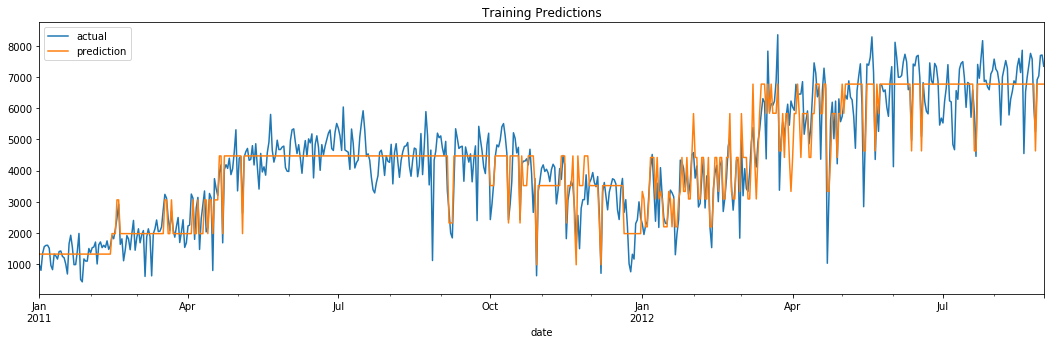

In [37]:
create_plot(train_df, tree, "Training Predictions")

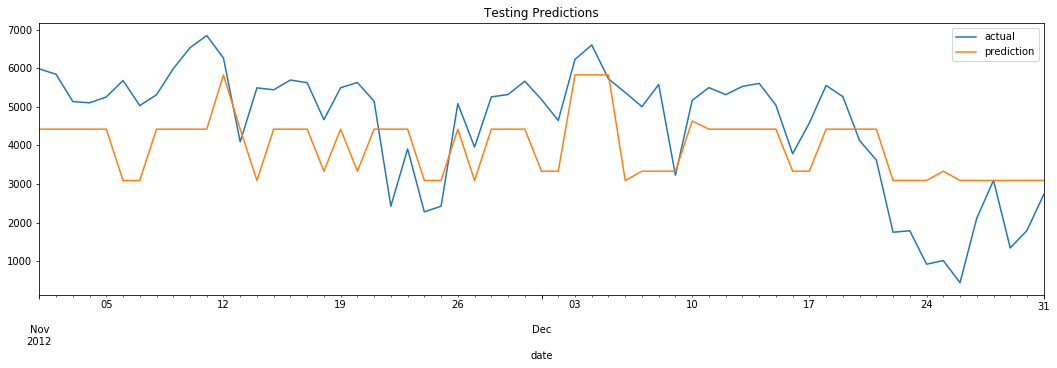

In [38]:
create_plot(test_df, tree, "Testing Predictions")

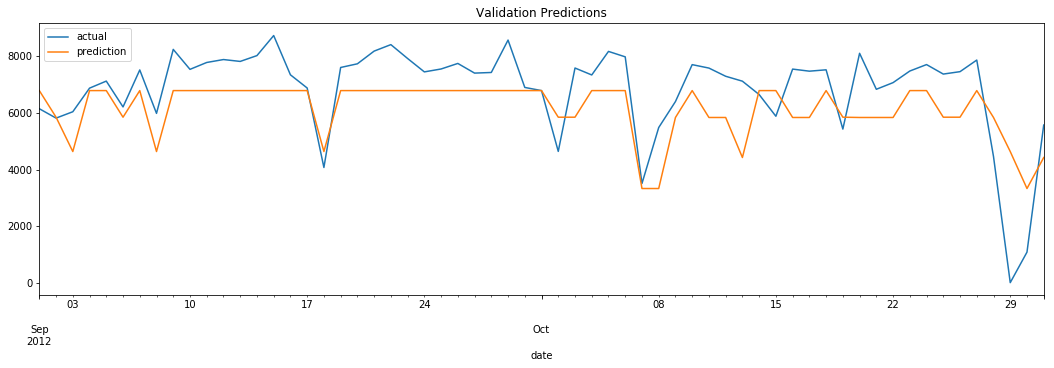

In [39]:
create_plot(val_df, tree, "Validation Predictions")